# Outliers detection

After cleaning the data from duplicates and missing values, we can now start to detect outliers.  
First we will import modules and load the cleaned data:

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/dataframes/final_cleaned.csv').iloc[:,1:]
df.shape

cat_cols = ['company_name','company_about', 'founded', 'business model','employees','product stage','status','funding stage','succeeded']
num_cols = ['total_raised','total_rounds', 'investors','ipo_price', 'geo_market_per']
tag_cols = [col for col in df.columns if col.startswith('tag_')]
targetmarket_cols = [col for col in df.columns if col.startswith('targetmarket_')]
sector_list = [col for col in df.columns if col.startswith("sector_")]
target_ind_list = [col for col in df.columns if col.startswith("industry_")]
technology_list = [col for col in df.columns if col.startswith("technology_")]
bin_cols = tag_cols + targetmarket_cols + sector_list + target_ind_list + technology_list

We deduced the relationship between columns can be seen as a graph, where each column presented as a **node**.  
To define the edges, we will use the **pandas.DataFrame.corr()** function,  
Each of the **edges** is a pair of highly correlated columns - above 0.7 correlation value:  
$$ \mid\text{pearson correlation [i][j]}\mid > 0.7 \quad\implies\quad (\text{columns[i]},\text{columns[j]}) \in E$$

We used NetworkX module to make the graph and run the algorithms on it.  
[NetworkX module docs](https://networkx.org/documentation/stable/index.html)

In [10]:
# %pip install networkx seaborn 
import networkx as nx

We can use <b>SCC algorithm</b> to find all strongly connected component in the graph, which represents <b>highly correlated columns</b>.  
For the most parts, our columns are structured in a way that theres a <b>certain inclusive tag</b> which can represent the exclusive tags that are highly correlated with.    
Between highly correlated chronic disease tag and celiac or diabetes tag one is more inclusive than the other. Therefore we will remove the exclusive ones.  
In our graph representation:  
$$
\text{an inclusive column} \iff {deg(\text{inclusive column}) > deg(\text{exclusive column})} 
$$ 
For each scc, we can infer and determine that the vertex with the highest degree can represent the other exclusive tags.  

If we will run SCC algorithm, we will get the number of highly correlated 'representitives' that will remain.

In [11]:
# e is a list of highly correlated pairs of tags
# We will use pandas corr function to find all correlations which absolute value greater than 0.7

def get_edges(df, v):
    df_cor = df[v].corr()
    E = []

    for i in range(len(df_cor.columns)):
        for j in range(i+1, len(df_cor.columns)):
            if abs(df_cor.iloc[i,j]) > 0.7:
                E.append((df_cor.columns[i], df_cor.columns[j]))
    return E


In [12]:
#  Runtime ~4 minutes

def scc(v, e):
    """
    Calculates the number of connected components in a graph with vertices v and edges e.
    """
    
    # Create a graph with v and e
    G = nx.Graph()
    G.add_nodes_from(v)
    G.add_edges_from(e)
    # Calculate the number of connected components
    return nx.number_connected_components(G)

scc(bin_cols, get_edges(df, bin_cols))


2599

In [13]:
# function to create a graph

def make_graph(V, E):
    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    return G

# function to return the max degree of a graph

def get_max_degree(G):
    max_degree = 0
    v = ''
    for vertex in G.nodes():
        if G.degree(vertex) > max_degree:
            max_degree = G.degree(vertex)
            v = vertex
    # print(max_degree)
    return v, max_degree
    
# function to remove all exclusive vertices
# Each iteration we find the vertex with max degree and remove all its adjacent vertices

def get_new_g(v,e):
    G = make_graph(v,e)

    v_name, max_degree = get_max_degree(G)
    removed = 0

    G2 = G.copy()
    while max_degree > 0:

        for adj in G.adj[v_name]:
            G2.remove_node(adj)
            removed += 1
            
        G = G2.copy()
        v_name, max_degree = get_max_degree(G)

    print(f"Total vertices removed: {removed}\n\n")
    return G

We will create the graph of the binary columns and run our algorithm on it.  
After the algorithm is done, the returned graph will include only **not** correlated columns.  
We will use the returned nodes to reduce the correlated columns in the dataframe.


In [14]:
# Runtime ~4.5 minutes

new_G = get_new_g(bin_cols,get_edges(df, bin_cols))

new_cols = list(new_G.nodes())
reduced_cols_df = df[cat_cols + num_cols + new_cols]
print(f'New dataframe shape: {reduced_cols_df.shape}')

Total vertices removed: 247


New dataframe shape: (10070, 2617)


After removing the correlated columns that doesn't contribute to the prediction, we can now look at the remaining columns:  
</br>
In our mostly binary dataset case, the outlier columns can be detected by the <b>sum of the 1 values in the column</b> - the column sum.  
After getting the sum of the column, we will use the following function on the values:  
$$
\text{value} = \frac{\text{number of 'succesful' companies with the tag}}{\text{total companies with the tag}}
$$
**This function can give us significant information about how the binary data relate to the success of the company.**  
We will then create a secondary dataset with the columns and their value.  
And check both <b>Z score</b> and <b>IQR</b> methods on the secondary dataset to detect the outliers columns.


We will start by calculating the columns sum and run the above function on them:

In [4]:
sum_dict = {}
for col in new_cols:
    sum_dict.update({col: reduced_cols_df[col].sum()})


In [6]:
#  Runtime ~10 minutes
! pip install tqdm
import tqdm.notebook as tqdm

temp_df = reduced_cols_df[reduced_cols_df['succeeded'] == 1]

new_values = {}

with tqdm.tqdm(total=len(new_cols)) as pbar:
    for col in new_cols:
        counter = 0
        
        for row in temp_df[col]:
            if row == 1:
                counter += 1
        pbar.update(1)
        new_values[col] = counter / sum_dict[col]


    

  0%|          | 0/2850 [00:00<?, ?it/s]

Lets plot the new values:

Text(0, 0.5, 'Frequency')

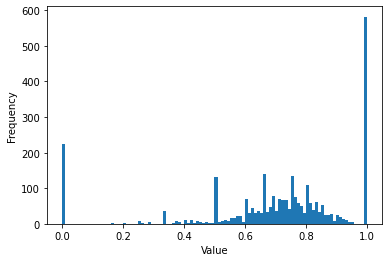

In [7]:
import matplotlib.pyplot as plt


plt.hist(new_values.values(), bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')


We see high rates of 1 and 0 in the new values.  
This means that those columns are not helpful for our analysis, either the sum was 0 or only a small amount of companies had the tag and succeeded - we will drop them.  
In addition, we can see a Gaussian bell distribution between values ~ 0.5 < X < 1  

Lets try to explore our data first:


In [8]:
norm_df = pd.DataFrame(new_values.values(), index=new_values.keys(), columns = ['value'])
norm_df.describe()

,value
count,2850.000000
mean,0.707236
std,0.263756
min,0.000000
25%,0.625000
50%,0.750000
75%,0.875000
max,1.000000


We see that the mean of the normalized values is ~0.71, and the standard deviation is ~0.23 - as we observed from the Gaussian distribution.  
We will now remove the columns with values 1 and 0 manualy to avoid biased mean and std values for a better outlier detection:

In [9]:
new_normalized = {}
for col, val in new_values.items():
    if val != 0 and val != 1 :
        new_normalized[col] = val
        
print(f'Total columns before: {len(new_values)}')
print(f'Total columns after: {len(new_normalized)}\n')

new_norm_ser = pd.DataFrame(new_normalized.values(), index=new_normalized.keys(), columns = ['value'])
new_norm_ser.describe()       

Total columns before: 2850
Total columns after: 2044



,value
count,2044.000000
mean,0.701381
std,0.133118
min,0.166667
25%,0.633725
50%,0.723439
75%,0.800000
max,0.958333


After removing 1 and 0 values, we remain with 1980 columns.  
Lets normalize the data and plot to see the bell better:

In [10]:
total = new_norm_ser['value'].sum()
new_norm_ser['normalized_value'] = new_norm_ser['value'] / total
new_norm_ser

,value,normalized_value
tag_computer-vision,0.724919,0.000506
tag_behavior-analytics,0.675214,0.000471
tag_machine-learning,0.758681,0.000529
tag_natural-language-processing,0.748299,0.000522
tag_foodtech,0.667647,0.000466
...,...,...
technology_Quantum Computing,0.625000,0.000436
technology_Data Storage_Flash,0.857143,0.000598
technology_Materials & Substances_Adhesive,0.727273,0.000507
technology_Sensing_Scent,0.750000,0.000523


Text(0, 0.5, 'Frequency')

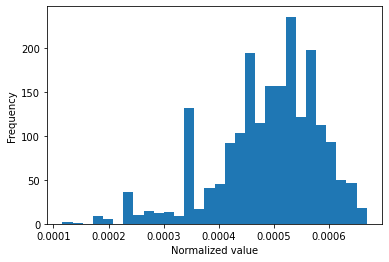

In [11]:
plt.hist(new_norm_ser['normalized_value'], bins=30)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

Now we can start detecting the outliers with the z_score and IQR methods.  
We will start by running a z_score method:

In [12]:
def outlier_detection_zscore(df_orig) -> pd.Series:
    
    df = df_orig.copy()
    z_score = (df['normalized_value'] - df['normalized_value'].mean()) / df['normalized_value'].std()
    outliers = abs(z_score) > 3

    return outliers

z_score_outliers = outlier_detection_zscore(new_norm_ser)
z_score_df = new_norm_ser[z_score_outliers == False]

print(z_score_outliers.value_counts())
print(f"Z Score detected {z_score_outliers.shape[0] - z_score_df.shape[0]} outliers")


False    2027
True       17
Name: normalized_value, dtype: int64
Z Score detected 17 outliers


Text(0, 0.5, 'Frequency')

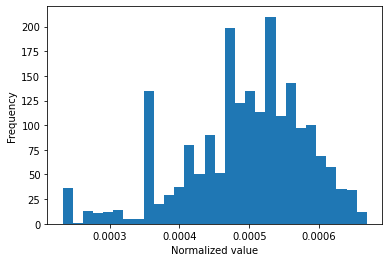

In [13]:
plt.hist(z_score_df['normalized_value'], bins=30)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

In [24]:
df_after_cols_reduction = reduced_cols_df.copy()
print(f'Before: {df_after_cols_reduction.shape}')

not_outliers_bin_cols = list(z_score_df.index)
df_after_cols_reduction = df_after_cols_reduction[cat_cols + num_cols + not_outliers_bin_cols]
print(f'After: {df_after_cols_reduction.shape}')

Before: (10070, 2617)
After: (10070, 1977)


We see that after <b>Z Score</b> detection method, we removed 17 columns.  

Now, we will try to use IQR method, and see the differences:  

In [15]:
iqr_norm = new_norm_ser.copy()
    
Q1 = np.percentile(iqr_norm['normalized_value'], 25)
Q3 = np.percentile(iqr_norm['normalized_value'], 75)
IQR = 1.5*(Q3 - Q1)

lower_bound = Q1 - IQR
upper_bound = Q3 + IQR

iqr_norm.loc[(iqr_norm["normalized_value"]> upper_bound) | (iqr_norm["normalized_value"]<lower_bound), 'iqr_outliers'] = True
iqr_norm.loc[(iqr_norm["normalized_value"]< upper_bound) & (iqr_norm["normalized_value"]>lower_bound), 'iqr_outliers'] = False

print(iqr_norm['iqr_outliers'].value_counts())




False    1981
True       63
Name: iqr_outliers, dtype: int64


Text(0, 0.5, 'Frequency')

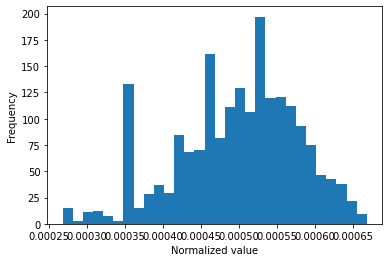

In [16]:
iqr_df = iqr_norm.copy()
for row in iqr_df.iterrows():
    if row[1]['iqr_outliers'] == True:
        iqr_df.drop(row[0], axis=0, inplace=True)

plt.hist(iqr_df['normalized_value'], bins=30)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

For comparison, we will plot both methods's results with sns.kdeplot:

In [27]:
df_after_cols_reduction = reduced_cols_df.copy()
print(f'Before: {df_after_cols_reduction.shape}')
not_outliers_bin_cols = list(iqr_df.index)
df_after_cols_reduction = df_after_cols_reduction[cat_cols + num_cols + not_outliers_bin_cols]
print(f'After: {df_after_cols_reduction.shape}')

Before: (10070, 2617)
After: (10070, 1927)


We see that after <b>IQR</b> detection method, we removed 67 columns.  

<AxesSubplot:xlabel='normalized_value', ylabel='Density'>

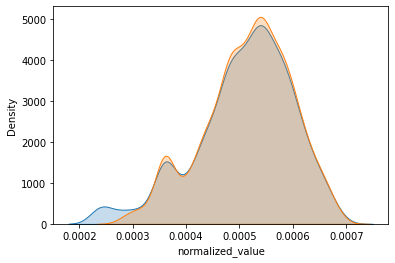

In [28]:
import seaborn as sns
ax = sns.kdeplot(z_score_df['normalized_value'], shade=True)
sns.kdeplot(iqr_df['normalized_value'], shade=True)

# Summary:
After checking both methods for detecting outliers - Z score and IQR, 
We observed that Z score results were inferior to IQR results.  
Therefore, we chose to use IQR detection method to remove outliers.

In [29]:
df_after_cols_reduction.to_csv('data/dataframes/df_after_cols_reduction.csv')

In this notebook we took the cleaned dataframe and tried to reduce the dimentionality of it.  
We did it firstly by removing highly correlated columns that gave no benefit to the prediction,  
Then we used the columns sum to find statistically significant insights and removed biased column,  
And lastly we used the z_score and IQR methods to detect outliers - we went with IQR method.  


In the next notebook we will run PCA algorithm on the remaining columns to reduce dimentions even better,  
Also, we will plot the PCA results and other properties to see if we can find any interesting insights.  
Next notebook: [EDA and PCA](4-eda-and-pca.ipynb)